*Spring runs from March 1 to May 31

*Summer runs from June 1 to August 31

*Fall (autumn) runs from September 1 to November 30

*Winter runs from December 1 to February 28 (February 29 in a leap year).

In [180]:
%matplotlib inline

In [558]:
# Dependencies and Setup
import matplotlib.cbook as cbook
import matplotlib.dates as dates
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import copy
from typing import List
import csv
import gmaps


Import saved csv. CSV includes data generated from 'StateCountySampleDataDF()' function.
Clean data.

In [80]:
# Import from .CSV
ca_la_df = pd.read_csv("./csv_data/california_data.csv") 

In [81]:
# Verify california is in dataframe
assert ca_la_df['state'][0] == 'California'

In [82]:
# Make copy before filtering
california_filtered_df = ca_la_df.copy()

### Clean dataset.

In [85]:
# Based off the scatter plot, outliers can be found with a sample data over 400. Show all outliers over 400 sample measurement.
outlier = california_filtered_df[(california_filtered_df[['sample_measurement']] > 400).all(axis=1)]
# Select certain columns to use for mapping, 
california_filtered_df=california_filtered_df[['county','site_number','sample_measurement','latitude','longitude','time_local','date_gmt','time_gmt','date_of_last_change']]
# Drop nan values and empty values
california_filtered_df=california_filtered_df.dropna()
# Remove all numbers below 0 and above 400
california_filtered_df=california_filtered_df[(california_filtered_df[['sample_measurement']] > 0).all(axis=1) & (california_filtered_df[['sample_measurement']] < 400).all(axis=1)]

In [90]:
ca_filtered_noIndexChange = california_filtered_df

In [91]:
# Assign date_gmt DateTimeIndex. Allows for date searching throug index.
california_filtered_df['date_gmt']=pd.DatetimeIndex(california_filtered_df['date_gmt'])
#Set index to date_gmt
california_filtered_df = california_filtered_df.set_index('date_gmt')

### Clean Copy dataset.

In [92]:
# Copy of clean data
ca_la_clean_data = california_filtered_df.copy()

### Filter: Seperate dataframes by Site Number

#### Site Number Seperation: Spring

In [229]:
# Seperate by site_number
spring_ca_la['site_number'].unique()
# Identify Site Number: 1103. Filter out values affiliated
site_number_1103=spring_ca_la[(spring_ca_la[['site_number']]==1103).all(axis=1)]

In [231]:
spring_sn_1103 = site_number_1103.copy()
spring_sn_1103.reset_index()
spring_sn_1103=spring_sn_1103.set_index('site_number')

* 34.06659,-118.22688= LA, CA. LA Department of Water and Power (1103)
* 33.79236,-118.17533= Long Beach, CA (4004)
* 34.14435,-117.85036= Glendora, CA (16)
* 34.19925,-118.53276= Reseda, CA (1201)
* 34.38344,-118.5284= Santa Clarita, CA (6012)
* 34.813034,-118.884819= Lebec, CA (9034)

### Begin IQR research - Annual Sample Results

In [473]:
# Copy of clean data
ca_la_box_data = ca_filtered_noIndexChange
# Sort Values
ca_la_box_data=ca_la_box_data.sort_values(["date_gmt", "time_gmt"])

In [474]:
# Set index to site_number. Sort values by site_number and time_gmt
ca_la_box_data.sort_values(by=['site_number','time_gmt'], ascending=True)
ca_la_box_data.head(6)

,county,site_number,sample_measurement,latitude,longitude,time_local,date_gmt,time_gmt,date_of_last_change
8099,Los Angeles,1103,45.0,34.06659,-118.22688,00:00,2019-01-01,08:00,2019-06-27
16139,Los Angeles,4004,9.4,33.79236,-118.17533,00:00,2019-01-01,08:00,2019-06-24
32219,Los Angeles,16,6.2,34.14435,-117.85036,00:00,2019-01-01,08:00,2019-06-24
40259,Los Angeles,1201,5.8,34.19925,-118.53276,00:00,2019-01-01,08:00,2019-06-24
8098,Los Angeles,1103,30.0,34.06659,-118.22688,01:00,2019-01-01,09:00,2019-06-27
16138,Los Angeles,4004,6.0,33.79236,-118.17533,01:00,2019-01-01,09:00,2019-06-24


In [475]:
# Filter DF to only columns used
filtered_ca_la_box_data = ca_la_box_data[['sample_measurement', 'site_number','time_gmt']].set_index('site_number').sort_values(by=['site_number','time_gmt'], ascending=True)
filtered_ca_la_box_data.head()

,sample_measurement,time_gmt
site_number,,
16,4.7,00:00
16,7.3,00:00
16,7.0,00:00
16,15.2,00:00
16,11.4,00:00


In [476]:
# Make a list of site_numbers. Used in for loops to grab specific data by site number & used for new df header.
filtered_ca_la_box_list = filtered_ca_la_box_data.index.unique().tolist()
filtered_ca_la_box_list

[16, 1103, 1201, 4004, 6012, 9034]

In [477]:
# Look through sample measurement list and count the amount of mice in each drug regimen.
# Create an empty list to fill with for loop
measurement_quartile=[]

# Search through filtered_ca_la_box_data with '.loc[site_number, 'sample_measurement' column]' and get the quartile
for i in filtered_ca_la_box_list:
    location = filtered_ca_la_box_data.loc[i, 'sample_measurement'].quantile(q=[.25, .5, .75])
    # append results to measurement_quartile list before moving to next value in tumor_regimen_list
    measurement_quartile.append(location)

In [478]:
measurement_quartile

[0.25     7.3
 0.50    11.2
 0.75    16.1
 Name: sample_measurement, dtype: float64,
 0.25     8.0
 0.50    12.0
 0.75    17.0
 Name: sample_measurement, dtype: float64,
 0.25     7.1
 0.50    10.9
 0.75    14.8
 Name: sample_measurement, dtype: float64,
 0.25     6.1
 0.50     9.3
 0.75    13.1
 Name: sample_measurement, dtype: float64,
 0.25     3.5
 0.50     6.8
 0.75    10.8
 Name: sample_measurement, dtype: float64,
 0.25    1.3
 0.50    2.2
 0.75    3.2
 Name: sample_measurement, dtype: float64]

In [479]:
iqr_all = []

# loop through measurement_quartile range (0-10). Find IQR by selecting one value at a time in the measurement_quartile list. 
for i in range(len(measurement_quartile)):
    iqr = (measurement_quartile[i][0.75])-(measurement_quartile[i][0.25])
    # Append finding to iqr_all list before moving to next value
    iqr_all.append(iqr)
#print(iqr_all)

In [480]:
# Show list. Verify we have correct amount
iqr_all

[8.8, 9.0, 7.700000000000001, 7.0, 7.300000000000001, 1.9000000000000001]

In [481]:
assert len(iqr_all) == 6

In [482]:
headers_list=['Glendora, CA (16)','Downtown LA (1103)','Reseda, CA (1201)','Long Beach, CA (4004)','Santa Clarita, CA (6012)','Lebec, CA (9034)']

In [483]:
# Round value.
round_iqr_all = [round(num, 2) for num in iqr_all]

# Combine both for loop generated list into one.
measurements_iqr_all = [dict(zip(headers_list, round_iqr_all))]
measurements_iqr_all

[{'Glendora, CA (16)': 8.8,
  'Downtown LA (1103)': 9.0,
  'Reseda, CA (1201)': 7.7,
  'Long Beach, CA (4004)': 7.0,
  'Santa Clarita, CA (6012)': 7.3,
  'Lebec, CA (9034)': 1.9}]

In [484]:
# Display in dataframe
measurements_iqr_all_df=pd.DataFrame(measurements_iqr_all)
measurements_iqr_all_df

,"Glendora, CA (16)",Downtown LA (1103),"Reseda, CA (1201)","Long Beach, CA (4004)","Santa Clarita, CA (6012)","Lebec, CA (9034)"
0,8.8,9.0,7.7,7.0,7.3,1.9


### Begin Box Plots - Annual Sample Results

In [485]:
# Values for plotting
box_plot_values = round_iqr_all
# Sort to determine outliers
values_sorted = sorted(box_plot_values)
print(values_sorted)

[1.9, 7.0, 7.3, 7.7, 8.8, 9.0]


In [486]:
# Reset dataframe for filtering
filtered_ca_la_box_data=filtered_ca_la_box_data.reset_index()

In [487]:
#Filter: By site location number. Set as own dataframe
ca_la_box_16=filtered_ca_la_box_data[filtered_ca_la_box_data['site_number'] == 16]
ca_la_box_1103=filtered_ca_la_box_data[filtered_ca_la_box_data['site_number'] == 1103]
ca_la_box_1201=filtered_ca_la_box_data[filtered_ca_la_box_data['site_number'] == 1201]
ca_la_box_4004=filtered_ca_la_box_data[filtered_ca_la_box_data['site_number'] == 4004]
ca_la_box_6012=filtered_ca_la_box_data[filtered_ca_la_box_data['site_number'] == 6012]
ca_la_box_9034=filtered_ca_la_box_data[filtered_ca_la_box_data['site_number'] == 9034]

In [488]:
# Sample measurement values per site location
site_16_measurements = ca_la_box_16['sample_measurement']
site_1103_measurements = ca_la_box_1103['sample_measurement']
site_1201_measurements = ca_la_box_1201['sample_measurement']
site_4004_measurements = ca_la_box_4004['sample_measurement']
site_6012_measurements = ca_la_box_6012['sample_measurement']
site_9034_measurements = ca_la_box_9034['sample_measurement']
total = len(site_16_measurements)+len(site_1103_measurements)+len(site_1201_measurements)+len(site_4004_measurements)+len(site_6012_measurements)+len(site_9034_measurements)

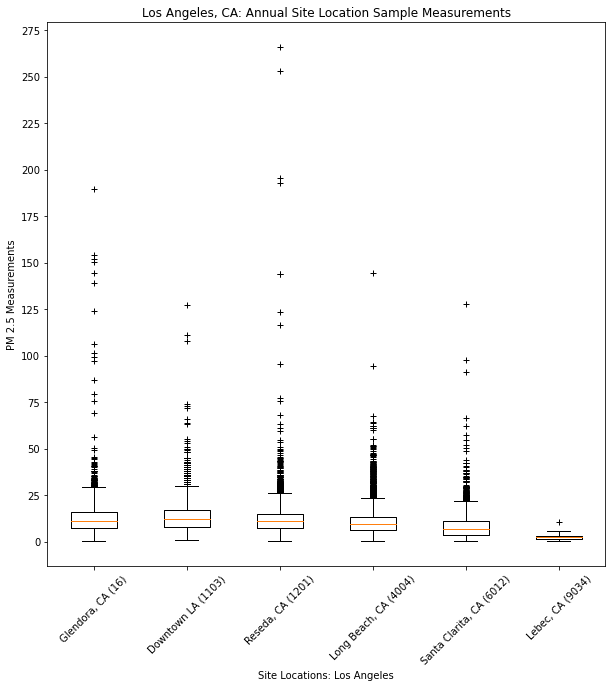

Total Samples Measured: 38400


In [489]:
# Generate a box plot of the sample measurement of each site location, annually
measurement_plot_info = [site_16_measurements,site_1103_measurements,site_1201_measurements,site_4004_measurements,site_6012_measurements,site_9034_measurements]
plot_labels = ['Site 16','Site 1103','Site 1201','Site 4004','Site 6012','Site 9034']
fig, ax = plt.subplots(figsize=(10, 10))
pos = np.array(range(len(measurement_plot_info))) + 1
bp = ax.boxplot(measurement_plot_info, sym='k+', showfliers=True)

ax.set_xticklabels(headers_list, rotation=45)
ax.set_yticks(range(0, 300, 25))
ax.set_xlabel('Site Locations: Los Angeles')
ax.set_ylabel('PM 2.5 Measurements')
ax.set_title('Los Angeles, CA: Annual Site Location Sample Measurements')
plt.show()
print(f'Total Samples Measured: {total}')

Potential Outliers

Filtering by outlier values and dates may tell us which day/month of the year has larger than normal air pollution measurements. 

In [490]:
# Glendora, CA (16) Outliers
glendora_annual_outliers = bp["fliers"][0].get_data()[1]
glendora_annual_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(site_16_measurements)}')
print(f'Total amount of outliers: {len(glendora_annual_outliers)}')
print(f'Glendora Outlier values: {glendora_annual_outliers}')

Total amount samples in set: 7858
Total amount of outliers: 97
Glendora Outlier values: [ 29.4  29.4  29.4  29.4  29.4  29.4  29.5  29.5  29.6  29.6  29.7  29.7
  29.8  29.9  29.9  29.9  30.2  30.2  30.4  30.4  30.4  30.4  30.6  30.6
  30.6  30.6  30.8  30.9  31.1  31.1  31.1  31.3  31.3  31.4  31.4  31.5
  31.6  31.8  31.8  31.8  32.   32.3  32.5  33.1  33.3  33.3  33.3  33.3
  33.3  33.6  33.6  33.8  33.8  34.   34.   34.3  34.5  35.   35.5  35.5
  35.7  37.   37.2  38.   38.   38.2  38.2  39.   40.   40.4  40.4  40.4
  41.4  41.6  42.4  42.6  44.5  45.   45.3  49.1  50.3  56.   69.3  75.6
  79.1  87.1  96.9  99.1 101.3 106.2 124.2 138.9 144.6 150.1 152.1 154.
 189.6]


In [491]:
# Downtown LA, CA (1103) Outliers
la_annual_outliers = bp["fliers"][1].get_data()[1]
la_annual_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(site_1103_measurements)}')
print(f'Total amount of outliers: {len(la_annual_outliers)}')
print(f'Downtown LA Outlier values: {la_annual_outliers}')

Total amount samples in set: 7784
Total amount of outliers: 185
Downtown LA Outlier values: [ 31.  31.  31.  31.  31.  31.  31.  31.  31.  31.  31.  31.  31.  31.
  31.  31.  31.  31.  31.  31.  31.  31.  31.  31.  32.  32.  32.  32.
  32.  32.  32.  32.  32.  32.  32.  32.  32.  32.  32.  32.  32.  32.
  32.  32.  32.  32.  32.  33.  33.  33.  33.  33.  33.  33.  33.  33.
  33.  33.  33.  33.  33.  33.  33.  33.  33.  33.  33.  34.  34.  34.
  34.  34.  34.  34.  34.  34.  34.  34.  34.  35.  35.  35.  35.  35.
  35.  35.  35.  36.  36.  36.  36.  36.  36.  36.  36.  36.  37.  37.
  37.  37.  37.  37.  37.  37.  37.  37.  37.  37.  37.  37.  38.  38.
  38.  38.  38.  38.  38.  38.  38.  38.  38.  38.  38.  38.  38.  39.
  39.  39.  39.  39.  39.  39.  39.  39.  39.  39.  39.  40.  40.  40.
  40.  40.  40.  40.  40.  41.  41.  41.  41.  42.  42.  42.  42.  42.
  42.  42.  43.  43.  43.  44.  45.  45.  45.  45.  45.  45.  48.  48.
  48.  49.  50.  50.  51.  53.  54.  55.  63.  64.  66. 

In [492]:
# Reseda, CA (1201) Outliers
reseda_annual_outliers = bp["fliers"][2].get_data()[1]
reseda_annual_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(site_1201_measurements)}')
print(f'Total amount of outliers: {len(reseda_annual_outliers)}')
print(f'Reseda Outlier values: {reseda_annual_outliers}')

Total amount samples in set: 7893
Total amount of outliers: 224
Reseda Outlier values: [ 26.4  26.4  26.4  26.4  26.5  26.5  26.5  26.5  26.6  26.6  26.6  26.7
  26.7  26.8  26.8  26.8  26.8  26.8  26.8  26.8  26.8  27.   27.   27.1
  27.1  27.2  27.2  27.2  27.3  27.4  27.5  27.5  27.5  27.5  27.5  27.5
  27.5  27.5  27.6  27.6  27.6  27.6  27.6  27.6  27.8  27.8  27.8  27.8
  27.9  28.   28.   28.   28.   28.   28.1  28.1  28.1  28.1  28.1  28.1
  28.1  28.1  28.3  28.3  28.3  28.4  28.4  28.5  28.5  28.6  28.6  28.7
  28.8  28.8  28.8  28.8  28.8  28.8  28.8  29.   29.   29.   29.   29.2
  29.2  29.3  29.3  29.3  29.3  29.3  29.3  29.3  29.3  29.4  29.5  29.5
  29.5  29.6  29.7  29.8  29.8  29.9  30.   30.   30.   30.1  30.1  30.3
  30.3  30.3  30.4  30.5  30.5  30.5  30.5  30.5  30.5  30.6  30.6  30.6
  30.7  31.   31.   31.   31.1  31.2  31.2  31.3  31.3  31.3  31.4  31.5
  31.5  31.6  31.7  31.9  32.   32.2  32.2  32.2  32.2  32.3  32.4  32.4
  32.5  32.7  32.9  33.1  33.1  33.4 

In [493]:
# Long Beach, CA (4004) Outliers
lb_annual_outliers = bp["fliers"][3].get_data()[1]
lb_annual_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(site_4004_measurements)}')
print(f'Total amount of outliers: {len(lb_annual_outliers)}')
print(f'Long Beach Outlier values: {lb_annual_outliers}')

Total amount samples in set: 7911
Total amount of outliers: 355
Long Beach Outlier values: [ 23.7  23.7  23.7  23.8  23.8  23.8  23.8  23.8  23.8  23.9  23.9  23.9
  23.9  23.9  23.9  23.9  24.1  24.1  24.1  24.1  24.1  24.1  24.2  24.2
  24.2  24.2  24.3  24.3  24.3  24.3  24.3  24.3  24.3  24.4  24.4  24.4
  24.4  24.4  24.4  24.4  24.4  24.4  24.4  24.6  24.6  24.6  24.6  24.6
  24.6  24.6  24.7  24.8  24.8  24.8  24.9  24.9  24.9  24.9  24.9  24.9
  24.9  24.9  25.1  25.1  25.1  25.1  25.1  25.1  25.1  25.1  25.2  25.2
  25.3  25.3  25.3  25.4  25.4  25.4  25.4  25.6  25.6  25.6  25.6  25.6
  25.6  25.6  25.7  25.8  25.8  25.9  25.9  25.9  25.9  26.   26.1  26.1
  26.1  26.3  26.3  26.3  26.4  26.4  26.4  26.4  26.4  26.4  26.4  26.4
  26.5  26.6  26.6  26.6  26.6  26.6  26.6  26.6  26.8  26.8  26.8  26.8
  26.9  26.9  27.1  27.1  27.1  27.3  27.3  27.3  27.4  27.4  27.4  27.4
  27.4  27.4  27.4  27.5  27.5  27.5  27.5  27.6  27.6  27.6  27.6  27.6
  27.6  27.6  27.8  27.8  27.8  2

In [494]:
# Santa Clarita, CA (6012) Outliers
santaclarita_annual_outliers = bp["fliers"][4].get_data()[1]
santaclarita_annual_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(site_6012_measurements)}')
print(f'Total amount of outliers: {len(santaclarita_annual_outliers)}')
print(f'Santa Clarita Outlier values: {santaclarita_annual_outliers}')

Total amount samples in set: 6905
Total amount of outliers: 185
Santa Clarita Outlier values: [ 21.8  21.8  21.9  21.9  21.9  21.9  21.9  21.9  21.9  21.9  21.9  21.9
  21.9  21.9  21.9  21.9  22.   22.1  22.1  22.1  22.1  22.1  22.1  22.1
  22.2  22.2  22.3  22.3  22.4  22.4  22.4  22.4  22.4  22.4  22.4  22.6
  22.6  22.6  22.6  22.6  22.7  22.8  22.8  22.8  22.8  22.8  22.9  22.9
  22.9  23.   23.1  23.1  23.1  23.1  23.1  23.3  23.3  23.3  23.3  23.3
  23.3  23.4  23.4  23.6  23.6  23.6  23.8  23.8  23.8  23.8  23.8  23.8
  23.8  23.8  23.9  24.1  24.1  24.1  24.1  24.2  24.3  24.3  24.3  24.3
  24.3  24.3  24.3  24.3  24.3  24.4  24.4  24.5  24.5  24.5  24.5  24.5
  24.5  24.7  24.8  24.8  24.9  25.   25.   25.1  25.3  25.3  25.3  25.5
  25.5  25.5  25.8  26.   26.   26.1  26.2  26.3  26.5  26.5  26.6  26.8
  26.8  27.   27.   27.2  27.2  27.5  27.7  27.7  28.4  28.4  28.6  28.6
  28.7  28.7  28.9  29.1  29.1  29.1  29.2  29.2  29.3  29.6  29.6  29.9
  30.1  30.1  30.4  31.9  32.1

In [495]:
# Lebec, CA (9034) Outliers
Lebec_annual_outliers = bp["fliers"][5].get_data()[1]
Lebec_annual_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(site_9034_measurements)}')
print(f'Total amount of outliers: {len(Lebec_annual_outliers)}')
print(f'Lebec Outlier values: {Lebec_annual_outliers}')

Total amount samples in set: 49
Total amount of outliers: 1
Lebec Outlier values: [10.4]


## Begin Season filtered analysis

### Season: Spring

In [496]:
# Sort by date_gmt and time_gmt
spring_ca_la = ca_la_clean_data['2019-03-01':'2019-05-31']
spring_ca_la

,county,site_number,sample_measurement,latitude,longitude,time_local,time_gmt,date_of_last_change
date_gmt,,,,,,,,
2019-04-06,Los Angeles,9034,1.4,34.813034,-118.884819,00:00,08:00,2020-03-04
2019-03-16,Los Angeles,9034,1.5,34.813034,-118.884819,00:00,08:00,2020-03-04
2019-04-21,Los Angeles,9034,3.0,34.813034,-118.884819,00:00,08:00,2020-03-04
2019-03-28,Los Angeles,9034,2.2,34.813034,-118.884819,00:00,08:00,2020-03-04
2019-05-09,Los Angeles,9034,3.0,34.813034,-118.884819,00:00,08:00,2020-04-14
...,...,...,...,...,...,...,...,...
2019-03-01,Los Angeles,1201,5.6,34.199250,-118.532760,20:00,04:00,2019-06-24
2019-03-01,Los Angeles,1201,6.9,34.199250,-118.532760,19:00,03:00,2019-06-24
2019-03-01,Los Angeles,1201,6.4,34.199250,-118.532760,18:00,02:00,2019-06-24


**Reset index for and set new index for box plot.**

In [497]:
spring_ca_la_box=spring_ca_la.reset_index().set_index('site_number').sort_values(by=['site_number','time_gmt'], ascending=True)

### Plot: Spring

Input dataframe name below. Make loop later.

In [498]:
# dataframe to plot
plot_df = spring_ca_la.copy()
#ax.plot(date, site_number_1103.sample_measurement)
plot_y_information = plot_df.sample_measurement

In [524]:
from matplotlib import cm

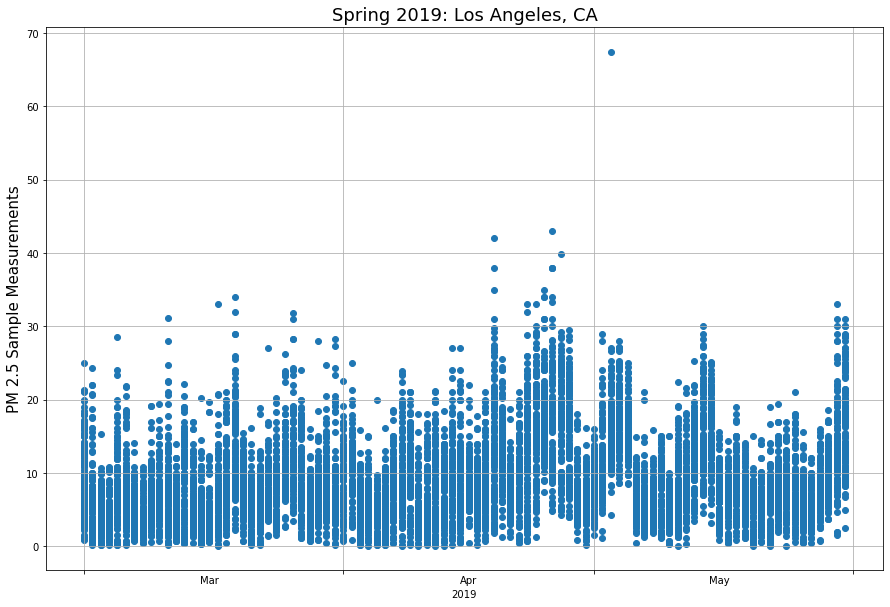

In [585]:
cmap = plt.cm.Spectral
norm = plt.Normalize(vmin=4, vmax=5)
z = np.array([4,4,5,4,5])

# Assigm date as index of dataframe. Dataframe index has dates
date = plot_df.index.astype('O')
# Plot subplots
fig, ax = plt.subplots(figsize=(15,10))

# Input plot parameters. Use dates in index to sample measurement

ax.scatter(date, plot_y_information)

# Set month in xaxis by searching date format
ax.xaxis.set_major_locator(dates.MonthLocator())
# 16 is a slight approximation since months differ in number of days.
ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))

# loop for custom tickers. Assign marker size and center text
for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')

imid = len(plot_df) // 2
ax.set_xlabel(str(date[imid].year))
ax.set_ylabel('PM 2.5 Sample Measurements', size=15)
ax.set_title('Spring 2019: Los Angeles, CA', size=18)
plt.grid(True)


plt.show()

#### Site Number Seperation: Spring

In [503]:
# Seperate by site_number
spring_ca_la['site_number'].unique()
# Identify Site Number: 1103. Filter out values affiliated
spring_site_number_16=spring_ca_la[(spring_ca_la[['site_number']]==16).all(axis=1)]
spring_site_number_1103=spring_ca_la[(spring_ca_la[['site_number']]==1103).all(axis=1)]
spring_site_number_1201=spring_ca_la[(spring_ca_la[['site_number']]==1201).all(axis=1)]
spring_site_number_4004=spring_ca_la[(spring_ca_la[['site_number']]==4004).all(axis=1)]
spring_site_number_6012=spring_ca_la[(spring_ca_la[['site_number']]==6012).all(axis=1)]
spring_site_number_9034=spring_ca_la[(spring_ca_la[['site_number']]==9034).all(axis=1)]

In [506]:
spring_site_number_16=spring_site_number_16[['site_number','sample_measurement','time_gmt']].reset_index().set_index('site_number').sort_values(by=['time_gmt'], ascending=True)
spring_site_number_1103=spring_site_number_1103[['site_number','sample_measurement','time_gmt']].reset_index().set_index('site_number').sort_values(by=['time_gmt'], ascending=True)
spring_site_number_1201=spring_site_number_1201[['site_number','sample_measurement','time_gmt']].reset_index().set_index('site_number').sort_values(by=['time_gmt'], ascending=True)
spring_site_number_4004=spring_site_number_4004[['site_number','sample_measurement','time_gmt']].reset_index().set_index('site_number').sort_values(by=['time_gmt'], ascending=True)
spring_site_number_6012=spring_site_number_6012[['site_number','sample_measurement','time_gmt']].reset_index().set_index('site_number').sort_values(by=['time_gmt'], ascending=True)
spring_site_number_9034=spring_site_number_9034[['site_number','sample_measurement','time_gmt']].reset_index().set_index('site_number').sort_values(by=['time_gmt'], ascending=True)

In [507]:
spring_site_number_16

,date_gmt,sample_measurement,time_gmt
site_number,,,
16,2019-03-01,8.5,00:00
16,2019-03-28,10.5,00:00
16,2019-05-21,5.9,00:00
16,2019-03-29,8.3,00:00
16,2019-03-30,9.5,00:00
...,...,...,...
16,2019-04-15,11.7,23:00
16,2019-05-11,11.9,23:00
16,2019-03-07,6.8,23:00


#### Begin IQR for Box Plots

In [510]:
# Look through sample measurement list and count the amount of mice in each drug regimen.
# Create an empty list to fill with for loop
measurement_quartile_spring=[]

# Search through filtered_ca_la_box_data with '.loc[site_number, 'sample_measurement' column]' and get the quartile
for i in filtered_ca_la_box_list:
    location = spring_ca_la_box.loc[i, 'sample_measurement'].quantile(q=[.25, .5, .75])
    # append results to measurement_quartile list before moving to next value in tumor_regimen_list
    measurement_quartile_spring.append(location)
measurement_quartile_spring

[0.25     6.800
 0.50     9.300
 0.75    13.375
 Name: sample_measurement, dtype: float64,
 0.25     6.0
 0.50    10.0
 0.75    14.0
 Name: sample_measurement, dtype: float64,
 0.25     5.300
 0.50     8.300
 0.75    11.875
 Name: sample_measurement, dtype: float64,
 0.25     4.8
 0.50     7.5
 0.75    11.1
 Name: sample_measurement, dtype: float64,
 0.25    2.8
 0.50    5.0
 0.75    8.7
 Name: sample_measurement, dtype: float64,
 0.25    1.80
 0.50    2.40
 0.75    3.05
 Name: sample_measurement, dtype: float64]

In [511]:
iqr_all_spring = []

# loop through measurement_quartile range (0-10). Find IQR by selecting one value at a time in the measurement_quartile list. 
for i in range(len(measurement_quartile_spring)):
    iqr = (measurement_quartile_spring[i][0.75])-(measurement_quartile_spring[i][0.25])
    # Append finding to iqr_all list before moving to next value
    iqr_all_spring.append(iqr)
#print(iqr_all_spring)

# Round numbers to 1 number after decimal.
round_iqr_all_spring = [round(num, 2) for num in iqr_all_spring]

In [512]:
# Show list. Verify we have correct amount
# iqr_all_spring

In [513]:
# Combine both for loop generated list into one.
measurements_iqr_all_spring = [dict(zip(headers_list, round_iqr_all_spring))]
measurements_iqr_all_spring

[{'Glendora, CA (16)': 6.58,
  'Downtown LA (1103)': 8.0,
  'Reseda, CA (1201)': 6.58,
  'Long Beach, CA (4004)': 6.3,
  'Santa Clarita, CA (6012)': 5.9,
  'Lebec, CA (9034)': 1.25}]

#### Begin Box Plots

In [514]:
# Values for plotting
box_values_spring = round_iqr_all_spring
# Sort to determine outliers
values_sorted_spring = sorted(box_values_spring)
print(values_sorted_spring)

[1.25, 5.9, 6.3, 6.58, 6.58, 8.0]


In [515]:
# Sample measurement values per site location
spring_site_16_measurements = spring_site_number_16['sample_measurement']
spring_site_1103_measurements = spring_site_number_1103['sample_measurement']
spring_site_1201_measurements = spring_site_number_1201['sample_measurement']
spring_site_4004_measurements = spring_site_number_4004['sample_measurement']
spring_site_6012_measurements = spring_site_number_6012['sample_measurement']
spring_site_9034_measurements = spring_site_number_9034['sample_measurement']

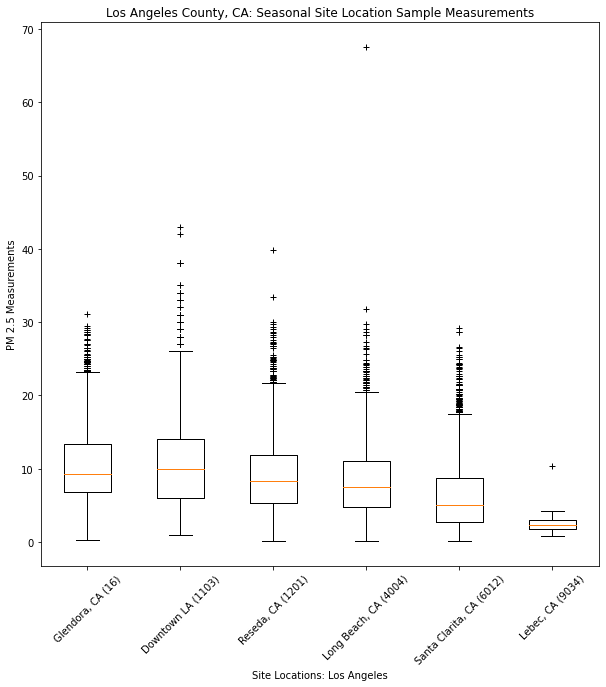

Number of Samples Measured: 10365


In [516]:
# Generate a box plot of the sample measurement of each site location, annually
measurement_plot_info = [spring_site_16_measurements,spring_site_1103_measurements,spring_site_1201_measurements,spring_site_4004_measurements,spring_site_6012_measurements,spring_site_9034_measurements]
plot_labels = ['Site 1103']
fig, ax = plt.subplots(figsize=(10, 10))
pos = np.array(range(len(measurement_plot_info))) + 1
bp = ax.boxplot(measurement_plot_info, sym='k+', showfliers=True)

ax.set_xticklabels(headers_list, rotation=45)
ax.set_xlabel('Site Locations: Los Angeles')
ax.set_ylabel('PM 2.5 Measurements')
ax.set_title('Los Angeles County, CA: Seasonal Site Location Sample Measurements')
plt.show()
print(f'Number of Samples Measured: {len(spring_ca_la)}')

Potential Outliers

Filtering by outlier values and dates may tell us which day/month of the year has larger than normal air pollution measurements. 

In [517]:
# Glendora, CA (16) Outliers
glendora_spring_outliers = bp["fliers"][0].get_data()[1]
glendora_spring_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(spring_site_16_measurements)}')
print(f'Total amount of outliers: {len(glendora_spring_outliers)}')
print(f'Glendora Outlier values: {glendora_spring_outliers}')

Total amount samples in set: 2086
Total amount of outliers: 83
Glendora Outlier values: [23.3 23.3 23.3 23.3 23.3 23.3 23.3 23.3 23.5 23.5 23.5 23.5 23.5 23.5
 23.7 23.8 23.8 23.8 24.  24.  24.  24.3 24.3 24.3 24.3 24.3 24.4 24.5
 24.5 24.5 24.5 24.5 24.5 24.5 24.5 24.5 24.5 24.5 24.5 24.5 24.7 24.7
 24.7 24.7 24.7 24.9 25.  25.  25.  25.  25.  25.  25.  25.2 25.3 25.3
 25.5 25.5 25.5 25.7 26.  26.  26.2 26.5 26.5 26.5 26.9 27.  27.  27.5
 27.5 27.7 28.2 28.2 28.4 28.4 28.7 28.7 28.9 28.9 29.2 29.5 31.1]


In [518]:
# Downtown LA, CA (1103) Outliers
la_spring_outliers = bp["fliers"][1].get_data()[1]
la_spring_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(spring_site_1103_measurements)}')
print(f'Total amount of outliers: {len(la_spring_outliers)}')
print(f'Downtown LA Outlier values: {la_spring_outliers}')

Total amount samples in set: 2194
Total amount of outliers: 54
Downtown LA Outlier values: [27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 28. 28. 28. 28. 28. 28. 28.
 29. 29. 29. 29. 29. 30. 30. 30. 30. 30. 31. 31. 31. 31. 31. 31. 31. 31.
 32. 32. 33. 33. 33. 33. 34. 34. 34. 34. 35. 35. 38. 38. 38. 38. 42. 43.]


In [519]:
# Reseda, CA (1201) Outliers
reseda_spring_outliers = bp["fliers"][2].get_data()[1]
reseda_spring_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(spring_site_1201_measurements)}')
print(f'Total amount of outliers: {len(reseda_spring_outliers)}')
print(f'Reseda Outlier values: {reseda_spring_outliers}')

Total amount samples in set: 2170
Total amount of outliers: 62
Reseda Outlier values: [21.9 21.9 21.9 21.9 22.1 22.1 22.1 22.1 22.1 22.1 22.3 22.4 22.4 22.4
 22.5 22.5 22.6 22.6 22.8 22.8 23.3 23.3 23.3 23.3 23.6 23.6 23.8 23.8
 23.8 24.  24.  24.3 24.5 24.7 24.8 24.8 24.8 24.8 25.  25.1 25.3 25.3
 25.5 26.5 26.7 26.7 26.8 27.  27.2 27.2 27.3 27.5 28.  28.3 28.5 28.7
 29.  29.3 29.8 30.  33.4 39.9]


In [520]:
# Long Beach, CA (4004) Outliers
lb_spring_outliers = bp["fliers"][3].get_data()[1]
lb_spring_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(spring_site_4004_measurements)}')
print(f'Total amount of outliers: {len(lb_spring_outliers)}')
print(f'Long Beach Outlier values: {lb_spring_outliers}')

Total amount samples in set: 2180
Total amount of outliers: 52
Long Beach Outlier values: [20.7 20.7 20.7 21.  21.  21.2 21.2 21.2 21.4 21.4 21.7 21.7 21.7 21.9
 21.9 22.1 22.1 22.2 22.4 22.4 22.6 22.6 22.6 22.9 23.2 23.4 23.4 23.4
 23.4 23.4 23.6 23.9 23.9 24.1 24.3 24.3 24.4 24.8 24.8 25.6 26.3 26.5
 26.8 27.3 28.3 28.3 28.3 28.6 29.  29.8 31.8 67.5]


In [521]:
# Santa Clarita, CA (6012) Outliers
santaclarita_spring_outliers = bp["fliers"][4].get_data()[1]
santaclarita_spring_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(spring_site_6012_measurements)}')
print(f'Total amount of outliers: {len(santaclarita_spring_outliers)}')
print(f'Santa Clarita Outlier values: {santaclarita_spring_outliers}')

Total amount samples in set: 1708
Total amount of outliers: 96
Santa Clarita Outlier values: [17.7 17.7 17.7 17.7 17.7 17.8 17.9 17.9 17.9 17.9 18.  18.  18.2 18.2
 18.2 18.2 18.4 18.4 18.4 18.4 18.4 18.5 18.7 18.7 18.7 18.7 18.7 18.9
 18.9 18.9 18.9 19.  19.  19.1 19.2 19.2 19.2 19.4 19.5 19.5 19.5 19.5
 19.7 19.7 19.7 19.9 20.  20.2 20.2 20.2 20.2 20.5 20.7 20.7 20.7 20.9
 20.9 20.9 20.9 20.9 21.4 21.4 21.4 21.4 21.6 21.6 21.9 22.2 22.2 22.4
 22.6 22.6 22.7 22.9 23.4 23.6 23.8 23.8 23.9 24.1 24.3 24.3 24.3 24.3
 24.4 25.  25.  25.3 25.3 25.5 26.1 26.5 26.6 28.6 28.7 29.2]


In [522]:
# Lebec, CA (9034) Outliers
Lebec_spring_outliers = bp["fliers"][5].get_data()[1]
Lebec_spring_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(spring_site_9034_measurements)}')
print(f'Total amount of outliers: {len(Lebec_spring_outliers)}')
print(f'Lebec Outlier values: {Lebec_spring_outliers}')

Total amount samples in set: 27
Total amount of outliers: 1
Lebec Outlier values: [10.4]


# LEFT OFF HERE. 5/15/2020. 10:12pm

### Season: Summer

In [42]:
# Sort by date_gmt and time_gmt
summer_ca_la = ca_la_clean_data['2019-06-01':'2019-08-31'].sort_values(["date_gmt", "time_gmt"])
summer_ca_la

,county,site_number,sample_measurement,latitude,longitude,time_local,time_gmt,date_of_last_change
date_gmt,,,,,,,,
2019-06-01,Los Angeles,1103,17.0,34.06659,-118.22688,16:00,00:00,2019-10-07
2019-06-01,Los Angeles,4004,8.2,33.79236,-118.17533,16:00,00:00,2019-10-07
2019-06-01,Los Angeles,6012,14.8,34.38344,-118.52840,16:00,00:00,2019-10-07
2019-06-01,Los Angeles,16,17.4,34.14435,-117.85036,16:00,00:00,2019-10-02
2019-06-01,Los Angeles,1201,17.0,34.19925,-118.53276,16:00,00:00,2019-10-07
...,...,...,...,...,...,...,...,...
2019-08-31,Los Angeles,1103,40.0,34.06659,-118.22688,15:00,23:00,2020-02-11
2019-08-31,Los Angeles,4004,15.6,33.79236,-118.17533,15:00,23:00,2020-02-10
2019-08-31,Los Angeles,6012,3.2,34.38344,-118.52840,15:00,23:00,2020-02-10


### Season: Fall

In [43]:
# Sort by date_gmt and time_gmt
fall_ca_la = ca_la_clean_data['2019-09-01':'2019-11-30'].sort_values(["date_gmt", "time_gmt"])
fall_ca_la

,county,site_number,sample_measurement,latitude,longitude,time_local,time_gmt,date_of_last_change
date_gmt,,,,,,,,
2019-09-01,Los Angeles,1103,15.0,34.06659,-118.22688,16:00,00:00,2020-02-11
2019-09-01,Los Angeles,4004,13.1,33.79236,-118.17533,16:00,00:00,2020-02-10
2019-09-01,Los Angeles,6012,1.8,34.38344,-118.52840,16:00,00:00,2020-02-10
2019-09-01,Los Angeles,16,15.4,34.14435,-117.85036,16:00,00:00,2020-02-06
2019-09-01,Los Angeles,1201,10.4,34.19925,-118.53276,16:00,00:00,2020-02-10
...,...,...,...,...,...,...,...,...
2019-11-30,Los Angeles,1103,5.0,34.06659,-118.22688,15:00,23:00,2020-03-31
2019-11-30,Los Angeles,4004,2.9,33.79236,-118.17533,15:00,23:00,2020-03-31
2019-11-30,Los Angeles,6012,5.4,34.38344,-118.52840,15:00,23:00,2020-03-25


### Season: Winter

In [47]:
# Beginning of the year Winter
# Sort by date_gmt and time_gmt
winter_begin_ca_la = ca_la_clean_data['2019-01-01':'2019-02'].sort_values(["date_gmt", "time_gmt"])
winter_begin_ca_la

,county,site_number,sample_measurement,latitude,longitude,time_local,time_gmt,date_of_last_change
date_gmt,,,,,,,,
2019-01-01,Los Angeles,1103,45.0,34.06659,-118.22688,00:00,08:00,2019-06-27
2019-01-01,Los Angeles,4004,9.4,33.79236,-118.17533,00:00,08:00,2019-06-24
2019-01-01,Los Angeles,16,6.2,34.14435,-117.85036,00:00,08:00,2019-06-24
2019-01-01,Los Angeles,1201,5.8,34.19925,-118.53276,00:00,08:00,2019-06-24
2019-01-01,Los Angeles,1103,30.0,34.06659,-118.22688,01:00,09:00,2019-06-27
...,...,...,...,...,...,...,...,...
2019-02-28,Los Angeles,1103,8.0,34.06659,-118.22688,15:00,23:00,2019-06-27
2019-02-28,Los Angeles,4004,3.1,33.79236,-118.17533,15:00,23:00,2019-06-24
2019-02-28,Los Angeles,6012,3.0,34.38344,-118.52840,15:00,23:00,2019-06-24


In [48]:
# End of the year Winter
# Sort by date_gmt and time_gmt
winter_end_ca_la = ca_la_clean_data['2019-12-01':'2019-12'].sort_values(["date_gmt", "time_gmt"])
winter_end_ca_la

,county,site_number,sample_measurement,latitude,longitude,time_local,time_gmt,date_of_last_change
date_gmt,,,,,,,,
2019-12-01,Los Angeles,1103,4.0,34.06659,-118.22688,16:00,00:00,2020-03-31
2019-12-01,Los Angeles,4004,1.9,33.79236,-118.17533,16:00,00:00,2020-03-31
2019-12-01,Los Angeles,6012,5.7,34.38344,-118.52840,16:00,00:00,2020-03-25
2019-12-01,Los Angeles,16,6.1,34.14435,-117.85036,16:00,00:00,2020-03-24
2019-12-01,Los Angeles,1201,13.0,34.19925,-118.53276,16:00,00:00,2020-03-25
...,...,...,...,...,...,...,...,...
2019-12-02,Los Angeles,1103,12.0,34.06659,-118.22688,23:00,07:00,2020-03-31
2019-12-02,Los Angeles,4004,24.9,33.79236,-118.17533,23:00,07:00,2020-03-31
2019-12-02,Los Angeles,6012,12.8,34.38344,-118.52840,23:00,07:00,2020-03-25
